# Teach network to be logic XOR gate: Deep Nural Networks Exc2 2021A

by: 

Shahar Raz

Yoav Raishfeld

## impots

In [ ]:
#imports 
%tensorflow_version 2.x
import tensorflow as tf
import json
from pprint import pprint
import torch
import pandas as pd
import matplotlib.pyplot as plt



## defining functions

In [ ]:
EPS = 0.7 # for aproximation of sigmoid to step fuction to BTU function (that is still be derived)
@tf.function
def BTU_layer(x, w, b): #calculates the output of the neuron (for all exmaples at once)  
    x = tf.cast(x, dtype=tf.float32)
    z = tf.matmul(x, w) + b
    return tf.nn.sigmoid(z / EPS) 

# compute loss on feed forward step
def Loss(out, t_train):
    return -tf.reduce_sum(t_train * tf.math.log(out) + (1.0 - t_train) * tf.math.log(1.0 - out)) # Elaboration?? 

# compute grads for back propagation
def grad(model, x_train, t_train):
    with tf.GradientTape() as t: # see in explenation at lecture 4
        loss = Loss(model(x_train), t_train) # (model's prediction - actual result)
    return t.gradient(loss, [model.w1, model.b1, model.w2, model.b2]), loss # t.gradient provides the gradient needed inorder to shrink the loss 
    
# 1 train step operation [a step[]
def train(model, x_train, t_train, optimizer):
    grads, loss = grad(model, x_train, t_train) # the function above 
    optimizer.apply_gradients(zip(grads, [model.w1, model.b1, model.w2, model.b2])) # Note1: using zip of the grads recievd be4 & the weights we want to change
                                                                                    # Note2: the order of the weights must be the same (rows 16&21)[w1,b1,w2,b2] 
    return loss

In [ ]:
# print(save_hlayer)

## defining model class

In [ ]:
class XOR_Net_Model:
  def __init__(self, num_hbridge, num_hidden, dim=2,num_outputs=1, ShortCut=False, print_n1=False):
    self.w1 = tf.Variable(tf.random.uniform([dim, num_hidden], -1, 1), name="weights1", trainable=True) ## w1 is the wieghts who enter the hidden layer
    self.w2 = tf.Variable(tf.random.uniform([num_hbridge, num_outputs], -1, 1), name="weights2", trainable=True )## w2 is the wieghts who enter the output layer
    self.b1 = tf.Variable(tf.zeros([num_hidden]), name="bias1", trainable=True) # biasses of the  hidden layer
    self.b2 = tf.Variable(tf.zeros([num_outputs]), name="bias2", trainable=True) # bias of th eoutput layer
    self.ShortCut = ShortCut # weather we'll use bypass or not
    self.print_n1 = print_n1
    self.save_hlayer = None
    
  # feed forward
  def __call__(self, x_train): 
    self.hlayer1 = BTU_layer(x_train, self.w1, self.b1) # Explenation??? 
    
    if self.ShortCut:
        self.hlayer1 = tf.concat([self.hlayer1, x_train], 1) #

    if self.print_n1 and len(self.hlayer1) == 4:
        self.save_hlayer = self.hlayer1
        # tf.print(save_hlayer)

    self.out = BTU_layer(self.hlayer1, self.w2, self.b2) # predicts 
    return self.out 

## Defining hyper parameters

In [ ]:
x_train = [[0, 0], [0, 1], [1, 0], [1, 1]] 
y_train = [[0], [1], [1], [0]]
x_valid = [[0, 0], [0, 1], [1, 0], [1, 1], [0.1, 0.1], [0.1, 0.9], [0.9, 0.1], [0.9, 0.9]]
y_valid=[[0], [1], [1], [0], [0], [1], [1], [0]]

dim_input = 2
num_epoches = 40000
train_thrashhold = 0.0001
min_unchanged_epochs = 10
loss_thrashold = 0.2
learning_rates = [0.1, 0.01]
hidden_neurons = [1, 2, 4] # here, we always have ONE hidden LAYER
need_bridge= [False, True]

hyperparametrs = {
    'max epoch': num_epoches,
    'stop_Min_loss': loss_thrashold,
    'd loss_Not_Improve_for': min_unchanged_epochs,
    'epocs Loss_Min_adv': train_thrashhold,
    'x train': x_train,
    'y train': y_train,
    'x valid': x_valid,
    'y valid': y_valid
}
x_train = tf.convert_to_tensor(x_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
x_valid = tf.convert_to_tensor(x_valid, dtype=tf.float32)
y_valid = tf.convert_to_tensor(y_valid, dtype=tf.float32)

## statistics class:

In [ ]:
def get_model_statics(summary:dict, fail:int):
    epoches, train, valid = [], [], []

    for one_run in summary:
        epoches.append(one_run['num_epoch'])
        train.append(one_run['train_loss'])
        valid.append(one_run['valid_loss'])

    epoches = np.array(epoches)
    train = np.array(train)
    valid = np.array(valid)

    statics = dict()
    statics['epoches'] = f'mean {np.mean(epoches)} std {round(np.std(epoches), 5)}'
    statics['train'] = f'mean {round(np.mean(train), 5)} std {round(np.std(train), 5)}'
    statics['valid'] = f'mean {round(np.mean(valid), 5)} std {round(np.std(valid), 5)}'
    # print('inside fail ', fail)
    statics['fail'] = f'fail {fail}'
    return statics




## Training loop

In [ ]:
from tqdm import tqdm_notebook as tqdm # tqdm is for progress indication
import numpy as np 


dic = {}
dic['hyperparametrs'] = hyperparametrs
failure = 0 
for lr in learning_rates: # 0.1 | 0.01
    for h_layer in hidden_neurons: # 1,2,4 neurons in hidden layer
        for isbridge in need_bridge: # using bypass or not

            if (h_layer == 1) and (not isbridge):
                continue #not a valid option, skip this!
            
            # train loop
            dic[f'lr: {lr}, hidden layer: {h_layer}, is bridge {isbridge}'] = [] # new dictionary?? 
            
            if isbridge: # bypass
                num_hbridge = h_layer + dim_input # add first layer's neuron as input to output layer
            else:
                num_hbridge = h_layer

            # define a model:
            failure = 0
            with tf.device('/device:GPU:0'):

                while len(dic[f'lr: {lr}, hidden layer: {h_layer}, is bridge {isbridge}']) < 11:

                    print(f'lr: {lr}, hidden layer: {h_layer}, is bridge {isbridge}')
                    
                    print_n1 = False
                    if h_layer == 1 and len(dic[f'lr: {lr}, hidden layer: {h_layer}, is bridge {isbridge}']) ==10:
                        print_n1 = True
                    model = XOR_Net_Model(num_hbridge, h_layer, ShortCut=isbridge, print_n1=print_n1) # creating the model

                    # set an optimizer:
                    optimizer = tf.compat.v1.train.GradientDescentOptimizer(lr) # setting up a new optimizer
                    prev_valid_loss = 0 # for checking if we stuck around the minimum, and don't change much
                    unchanged_epocs_counter = 0
                    not_fail = False
                    for i in tqdm(range(num_epoches)): # what is this tqdm range type??
                        train_loss = train(model, x_train, y_train, optimizer) # getting the loss 
                        valid_loss = Loss(model(x_valid), y_valid)  
                        if i % 4000 == 0:
                            print(f"\nTrain Epoc: {i}, loss: {train_loss}")
                            print(f"\nValidition Epoc: {i}, loss: {valid_loss}")
                        if np.isnan(train_loss) or np.isnan(valid_loss):
                            failure += 1
                            break

                        if (prev_valid_loss - valid_loss) < train_thrashhold:
                            unchanged_epocs_counter+=1
                        else:
                            unchanged_epocs_counter = 0
                        
                        if unchanged_epocs_counter >= min_unchanged_epochs and valid_loss < loss_thrashold:
                            d = {
                                    'num_epoch': i,
                                    'train_loss': train_loss.numpy(),
                                    'valid_loss': valid_loss.numpy()
                                }
                            dic[f'lr: {lr}, hidden layer: {h_layer}, is bridge {isbridge}'].append(d)
                            # save it!
                            not_fail = True
                            break
                    if not not_fail:
                        failure += 1
                print(f'failure {failure}')
                 #save for statistics anlysis
                dic[f'lr: {lr}, hidden layer: {h_layer}, is bridge {isbridge}'] = get_model_statics(dic[f'lr: {lr}, hidden layer: {h_layer}, is bridge {isbridge}'],
                                                                                                failure)
                # for q3 (desription in next 2 cells)
                if h_layer == 1:
                    # print('This is the last hidden layer to print:')
                    save_last_layer = model.save_hlayer
                    # tf.print(model.save_hlayer)
                    # print('and the output of the net is:')
                    # tf.print(model(x_train))

                #save weights values,in the case of timeout 
                torch.save(dic, '/content/sample_data/dic.pt')
                with open('/content/sample_data/save_file.txt', 'wt') as out:
                    pprint(dic, stream=out)
                
    


lr: 0.1, hidden layer: 1, is bridge True


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:41: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



Train Epoc: 0, loss: 3.7987966537475586

Validition Epoc: 0, loss: 6.592063903808594
lr: 0.1, hidden layer: 1, is bridge True



Train Epoc: 0, loss: 3.7487246990203857

Validition Epoc: 0, loss: 6.57879638671875
lr: 0.1, hidden layer: 1, is bridge True



Train Epoc: 0, loss: 3.0817699432373047

Validition Epoc: 0, loss: 5.977005958557129
lr: 0.1, hidden layer: 1, is bridge True



Train Epoc: 0, loss: 3.5862369537353516

Validition Epoc: 0, loss: 6.478175163269043

Train Epoc: 4000, loss: 0.06368014216423035

Validition Epoc: 4000, loss: 0.21210716664791107
lr: 0.1, hidden layer: 1, is bridge True



Train Epoc: 0, loss: 3.308316707611084

Validition Epoc: 0, loss: 6.199694633483887
lr: 0.1, hidden layer: 1, is bridge True



Train Epoc: 0, loss: 2.9033892154693604

Validition Epoc: 0, loss: 5.675615310668945
lr: 0.1, hidden layer: 1, is bridge True



Train Epoc: 0, loss: 3.051513195037842

Validition Epoc: 0, loss: 5.884176254272461
lr: 0.1, hidden layer: 1, is bridge True



Train Epoc: 0, loss: 3.290980577468872

Validition Epoc: 0, loss: 6.179242134094238
lr: 0.1, hidden layer: 1, is bridge True



Train Epoc: 0, loss: 2.8725132942199707

Validition Epoc: 0, loss: 5.690765857696533
lr: 0.1, hidden layer: 1, is bridge True



Train Epoc: 0, loss: 3.608513593673706

Validition Epoc: 0, loss: 6.316404342651367
lr: 0.1, hidden layer: 1, is bridge True



Train Epoc: 0, loss: 2.9378299713134766

Validition Epoc: 0, loss: 5.77897310256958
failure 0
lr: 0.1, hidden layer: 2, is bridge False



Train Epoc: 0, loss: 3.006084680557251

Validition Epoc: 0, loss: 5.759321212768555

Train Epoc: 4000, loss: 1.3955845832824707

Validition Epoc: 4000, loss: 2.824190616607666

Train Epoc: 8000, loss: 1.3905525207519531

Validition Epoc: 8000, loss: 2.803236961364746

Train Epoc: 12000, loss: 1.3890351057052612

Validition Epoc: 12000, loss: 2.795787811279297

Train Epoc: 16000, loss: 1.3883090019226074

Validition Epoc: 16000, loss: 2.7918152809143066

Train Epoc: 20000, loss: 1.387884497642517

Validition Epoc: 20000, loss: 2.789292812347412

Train Epoc: 24000, loss: 1.387606143951416

Validition Epoc: 24000, loss: 2.787525177001953

Train Epoc: 28000, loss: 1.3874101638793945

Validition Epoc: 28000, loss: 2.7862062454223633

Train Epoc: 32000, loss: 1.387264370918274

Validition Epoc: 32000, loss: 2.7851765155792236

Train Epoc: 36000, loss: 1.3871524333953857

Validition Epoc: 36000, loss: 2.784346103668213

lr: 0.1, hidden layer: 2, is bridge False



Train Epoc: 0, loss: 2.83530592918396

Validition Epoc: 0, loss: 5.613022327423096
lr: 0.1, hidden layer: 2, is bridge False



Train Epoc: 0, loss: 2.9931344985961914

Validition Epoc: 0, loss: 5.750141620635986
lr: 0.1, hidden layer: 2, is bridge False



Train Epoc: 0, loss: 2.78609037399292

Validition Epoc: 0, loss: 5.557330131530762
lr: 0.1, hidden layer: 2, is bridge False




Train Epoc: 0, loss: 3.881462574005127

Validition Epoc: 0, loss: 6.544955253601074
lr: 0.1, hidden layer: 2, is bridge False



Train Epoc: 0, loss: 2.7758469581604004

Validition Epoc: 0, loss: 5.5436248779296875
lr: 0.1, hidden layer: 2, is bridge False



Train Epoc: 0, loss: 2.973125457763672

Validition Epoc: 0, loss: 5.739053249359131

Train Epoc: 4000, loss: 1.3958649635314941

Validition Epoc: 4000, loss: 2.825063467025757

Train Epoc: 8000, loss: 1.3906059265136719

Validition Epoc: 8000, loss: 2.803405284881592

Train Epoc: 12000, loss: 1.3890552520751953

Validition Epoc: 12000, loss: 2.7958502769470215

Train Epoc: 16000, loss: 1.3883190155029297

Validition Epoc: 16000, loss: 2.79184627532959

Train Epoc: 20000, loss: 1.3878902196884155

Validition Epoc: 20000, loss: 2.7893118858337402

Train Epoc: 24000, loss: 1.3876101970672607

Validition Epoc: 24000, loss: 2.787539482116699

Train Epoc: 28000, loss: 1.3874123096466064

Validition Epoc: 28000, loss: 2.786217212677002

Train Epoc: 32000, loss: 1.3872661590576172

Validition Epoc: 32000, loss: 2.7851855754852295

Train Epoc: 36000, loss: 1.3871536254882812

Validition Epoc: 36000, loss: 2.7843551635742188

lr: 0.1, hidden layer: 2, is bridge False



Train Epoc: 0, loss: 3.0326180458068848

Validition Epoc: 0, loss: 5.7857346534729
lr: 0.1, hidden layer: 2, is bridge False



Train Epoc: 0, loss: 3.2220726013183594

Validition Epoc: 0, loss: 5.879197120666504

Train Epoc: 4000, loss: 1.39382004737854

Validition Epoc: 4000, loss: 2.8201065063476562

Train Epoc: 8000, loss: 1.3897815942764282

Validition Epoc: 8000, loss: 2.801875114440918

Train Epoc: 12000, loss: 1.3885475397109985

Validition Epoc: 12000, loss: 2.7951912879943848

Train Epoc: 16000, loss: 1.3879526853561401

Validition Epoc: 16000, loss: 2.791565418243408

Train Epoc: 20000, loss: 1.387603998184204

Validition Epoc: 20000, loss: 2.7892403602600098

Train Epoc: 24000, loss: 1.387375831604004

Validition Epoc: 24000, loss: 2.7875967025756836

Train Epoc: 28000, loss: 1.3872145414352417

Validition Epoc: 28000, loss: 2.78635835647583

Train Epoc: 32000, loss: 1.3870947360992432

Validition Epoc: 32000, loss: 2.785386562347412

Train Epoc: 36000, loss: 1.387001395225525

Validition Epoc: 36000, loss: 2.7845981121063232

lr: 0.1, hidden layer: 2, is bridge False



Train Epoc: 0, loss: 2.815531015396118

Validition Epoc: 0, loss: 5.591800689697266
lr: 0.1, hidden layer: 2, is bridge False



Train Epoc: 0, loss: 2.8963284492492676

Validition Epoc: 0, loss: 5.663025856018066
lr: 0.1, hidden layer: 2, is bridge False



Train Epoc: 0, loss: 2.7231602668762207

Validition Epoc: 0, loss: 5.4578962326049805
lr: 0.1, hidden layer: 2, is bridge False



Train Epoc: 0, loss: 2.805687427520752

Validition Epoc: 0, loss: 5.594890117645264

Train Epoc: 4000, loss: 1.9195748567581177

Validition Epoc: 4000, loss: 3.9319214820861816

Train Epoc: 8000, loss: 1.9141764640808105

Validition Epoc: 8000, loss: 3.917910099029541

Train Epoc: 12000, loss: 1.9125233888626099

Validition Epoc: 12000, loss: 3.9145450592041016

Train Epoc: 16000, loss: 1.9117302894592285

Validition Epoc: 16000, loss: 3.9136388301849365

Train Epoc: 20000, loss: 1.9112660884857178

Validition Epoc: 20000, loss: 3.913639545440674

Train Epoc: 24000, loss: 1.9109623432159424

Validition Epoc: 24000, loss: 3.914031982421875

Train Epoc: 28000, loss: 1.9107482433319092

Validition Epoc: 28000, loss: 3.9146153926849365

Train Epoc: 32000, loss: 1.9105889797210693

Validition Epoc: 32000, loss: 3.9152987003326416

Train Epoc: 36000, loss: 1.9104671478271484

Validition Epoc: 36000, loss: 3.9160308837890625

lr: 0.1, hidden layer: 2, is bridge False



Train Epoc: 0, loss: 2.7848947048187256

Validition Epoc: 0, loss: 5.558562278747559
lr: 0.1, hidden layer: 2, is bridge False



Train Epoc: 0, loss: 2.839935779571533

Validition Epoc: 0, loss: 5.605562210083008

Train Epoc: 4000, loss: 1.3945388793945312

Validition Epoc: 4000, loss: 2.8242440223693848

Train Epoc: 8000, loss: 1.3899121284484863

Validition Epoc: 8000, loss: 2.803497314453125

Train Epoc: 12000, loss: 1.3885960578918457

Validition Epoc: 12000, loss: 2.796267509460449

Train Epoc: 16000, loss: 1.387977123260498

Validition Epoc: 16000, loss: 2.792403221130371

Train Epoc: 20000, loss: 1.3876179456710815

Validition Epoc: 20000, loss: 2.7899365425109863

Train Epoc: 24000, loss: 1.3873844146728516

Validition Epoc: 24000, loss: 2.788201332092285

Train Epoc: 28000, loss: 1.387220859527588

Validition Epoc: 28000, loss: 2.786900043487549

Train Epoc: 32000, loss: 1.387099027633667

Validition Epoc: 32000, loss: 2.7858753204345703

Train Epoc: 36000, loss: 1.3870054483413696

Validition Epoc: 36000, loss: 2.7850489616394043

lr: 0.1, hidden layer: 2, is bridge False



Train Epoc: 0, loss: 3.3829598426818848

Validition Epoc: 0, loss: 6.097247123718262

Train Epoc: 4000, loss: 1.3953827619552612

Validition Epoc: 4000, loss: 2.822871446609497

Train Epoc: 8000, loss: 1.3905093669891357

Validition Epoc: 8000, loss: 2.80228328704834

Train Epoc: 12000, loss: 1.38901948928833

Validition Epoc: 12000, loss: 2.794900894165039

Train Epoc: 16000, loss: 1.3883020877838135

Validition Epoc: 16000, loss: 2.790959596633911

Train Epoc: 20000, loss: 1.3878815174102783

Validition Epoc: 20000, loss: 2.7884583473205566

Train Epoc: 24000, loss: 1.3876047134399414

Validition Epoc: 24000, loss: 2.786709785461426

Train Epoc: 28000, loss: 1.3874099254608154

Validition Epoc: 28000, loss: 2.7854056358337402

Train Epoc: 32000, loss: 1.3872644901275635

Validition Epoc: 32000, loss: 2.7843894958496094

Train Epoc: 36000, loss: 1.3871524333953857

Validition Epoc: 36000, loss: 2.783571720123291

lr: 0.1, hidden layer: 2, is bridge False



Train Epoc: 0, loss: 2.9559988975524902

Validition Epoc: 0, loss: 5.7122297286987305

Train Epoc: 4000, loss: 1.3947991132736206

Validition Epoc: 4000, loss: 2.82525634765625

Train Epoc: 8000, loss: 1.3899941444396973

Validition Epoc: 8000, loss: 2.8036203384399414

Train Epoc: 12000, loss: 1.3886387348175049

Validition Epoc: 12000, loss: 2.796191692352295

Train Epoc: 16000, loss: 1.3880045413970947

Validition Epoc: 16000, loss: 2.792255401611328

Train Epoc: 20000, loss: 1.3876382112503052

Validition Epoc: 20000, loss: 2.7897565364837646

Train Epoc: 24000, loss: 1.387400507926941

Validition Epoc: 24000, loss: 2.788003921508789

Train Epoc: 28000, loss: 1.3872328996658325

Validition Epoc: 28000, loss: 2.786693572998047

Train Epoc: 32000, loss: 1.3871084451675415

Validition Epoc: 32000, loss: 2.7856693267822266

Train Epoc: 36000, loss: 1.3870130777359009

Validition Epoc: 36000, loss: 2.784836769104004

lr: 0.1, hidden layer: 2, is bridge False



Train Epoc: 0, loss: 2.7969493865966797

Validition Epoc: 0, loss: 5.570092678070068
failure 7
lr: 0.1, hidden layer: 2, is bridge True



Train Epoc: 0, loss: 3.025470733642578

Validition Epoc: 0, loss: 5.776826858520508
lr: 0.1, hidden layer: 2, is bridge True



Train Epoc: 0, loss: 3.2176296710968018

Validition Epoc: 0, loss: 5.995112895965576
lr: 0.1, hidden layer: 2, is bridge True



Train Epoc: 0, loss: 3.4702014923095703

Validition Epoc: 0, loss: 6.225205421447754
lr: 0.1, hidden layer: 2, is bridge True



Train Epoc: 0, loss: 3.1286678314208984

Validition Epoc: 0, loss: 5.830845355987549
lr: 0.1, hidden layer: 2, is bridge True



Train Epoc: 0, loss: 3.524836778640747

Validition Epoc: 0, loss: 6.174020767211914
lr: 0.1, hidden layer: 2, is bridge True



Train Epoc: 0, loss: 2.9468798637390137

Validition Epoc: 0, loss: 5.798831462860107
lr: 0.1, hidden layer: 2, is bridge True



Train Epoc: 0, loss: 3.000343084335327

Validition Epoc: 0, loss: 5.817753791809082
lr: 0.1, hidden layer: 2, is bridge True



Train Epoc: 0, loss: 2.9928064346313477

Validition Epoc: 0, loss: 5.670563697814941
lr: 0.1, hidden layer: 2, is bridge True



Train Epoc: 0, loss: 3.0721828937530518

Validition Epoc: 0, loss: 5.851115703582764
lr: 0.1, hidden layer: 2, is bridge True



Train Epoc: 0, loss: 2.968705892562866

Validition Epoc: 0, loss: 5.8088202476501465
lr: 0.1, hidden layer: 2, is bridge True



Train Epoc: 0, loss: 3.0110533237457275

Validition Epoc: 0, loss: 5.863765239715576
failure 0
lr: 0.1, hidden layer: 4, is bridge False



Train Epoc: 0, loss: 2.8919992446899414

Validition Epoc: 0, loss: 5.606581687927246
lr: 0.1, hidden layer: 4, is bridge False



Train Epoc: 0, loss: 3.4195375442504883

Validition Epoc: 0, loss: 5.947160720825195
lr: 0.1, hidden layer: 4, is bridge False



Train Epoc: 0, loss: 2.833986282348633

Validition Epoc: 0, loss: 5.6034393310546875
lr: 0.1, hidden layer: 4, is bridge False



Train Epoc: 0, loss: 3.8492212295532227

Validition Epoc: 0, loss: 6.344609260559082
lr: 0.1, hidden layer: 4, is bridge False



Train Epoc: 0, loss: 2.9857325553894043

Validition Epoc: 0, loss: 5.679018020629883

lr: 0.1, hidden layer: 4, is bridge False



Train Epoc: 0, loss: 3.4443695545196533

Validition Epoc: 0, loss: 6.087554931640625
lr: 0.1, hidden layer: 4, is bridge False



Train Epoc: 0, loss: 3.047175884246826

Validition Epoc: 0, loss: 5.770557403564453
lr: 0.1, hidden layer: 4, is bridge False



Train Epoc: 0, loss: 3.0289201736450195

Validition Epoc: 0, loss: 5.806460380554199
lr: 0.1, hidden layer: 4, is bridge False



Train Epoc: 0, loss: 2.836699962615967

Validition Epoc: 0, loss: 5.60196590423584
lr: 0.1, hidden layer: 4, is bridge False



Train Epoc: 0, loss: 3.069464683532715

Validition Epoc: 0, loss: 5.765586853027344
lr: 0.1, hidden layer: 4, is bridge False



Train Epoc: 0, loss: 2.821230411529541

Validition Epoc: 0, loss: 5.558503150939941
failure 0
lr: 0.1, hidden layer: 4, is bridge True



Train Epoc: 0, loss: 3.1758275032043457

Validition Epoc: 0, loss: 6.078224182128906
lr: 0.1, hidden layer: 4, is bridge True



Train Epoc: 0, loss: 3.0523157119750977

Validition Epoc: 0, loss: 5.828069686889648
lr: 0.1, hidden layer: 4, is bridge True



Train Epoc: 0, loss: 3.419438600540161

Validition Epoc: 0, loss: 5.814363956451416
lr: 0.1, hidden layer: 4, is bridge True



Train Epoc: 0, loss: 3.4856314659118652

Validition Epoc: 0, loss: 6.237006187438965
lr: 0.1, hidden layer: 4, is bridge True



Train Epoc: 0, loss: 2.8569512367248535

Validition Epoc: 0, loss: 5.632840633392334
lr: 0.1, hidden layer: 4, is bridge True




Train Epoc: 0, loss: 2.995425224304199

Validition Epoc: 0, loss: 5.666439056396484
lr: 0.1, hidden layer: 4, is bridge True



Train Epoc: 0, loss: 2.8965017795562744

Validition Epoc: 0, loss: 5.725892066955566
lr: 0.1, hidden layer: 4, is bridge True



Train Epoc: 0, loss: 3.380739688873291

Validition Epoc: 0, loss: 6.180992126464844
lr: 0.1, hidden layer: 4, is bridge True



Train Epoc: 0, loss: 2.954667091369629

Validition Epoc: 0, loss: 5.687673568725586
lr: 0.1, hidden layer: 4, is bridge True



Train Epoc: 0, loss: 2.93723201751709

Validition Epoc: 0, loss: 5.688515663146973
lr: 0.1, hidden layer: 4, is bridge True



Train Epoc: 0, loss: 2.9920411109924316

Validition Epoc: 0, loss: 5.8364105224609375
failure 0
lr: 0.01, hidden layer: 1, is bridge True



Train Epoc: 0, loss: 2.9773201942443848

Validition Epoc: 0, loss: 5.8789896965026855

Train Epoc: 4000, loss: 2.486231803894043

Validition Epoc: 4000, loss: 5.056304454803467

Train Epoc: 8000, loss: 0.4463650584220886

Validition Epoc: 8000, loss: 1.131870985031128

Train Epoc: 12000, loss: 0.19593122601509094

Validition Epoc: 12000, loss: 0.5579334497451782

Train Epoc: 16000, loss: 0.12285883724689484

Validition Epoc: 16000, loss: 0.37721794843673706

Train Epoc: 20000, loss: 0.08896077424287796

Validition Epoc: 20000, loss: 0.28922826051712036

Train Epoc: 24000, loss: 0.06955414265394211

Validition Epoc: 24000, loss: 0.23693589866161346

Train Epoc: 28000, loss: 0.05702758580446243

Validition Epoc: 28000, loss: 0.20211857557296753
lr: 0.01, hidden layer: 1, is bridge True



Train Epoc: 0, loss: 4.132000923156738

Validition Epoc: 0, loss: 8.079414367675781

Train Epoc: 4000, loss: 0.5812151432037354

Validition Epoc: 4000, loss: 1.387854814529419

Train Epoc: 8000, loss: 0.21640247106552124

Validition Epoc: 8000, loss: 0.579161524772644

Train Epoc: 12000, loss: 0.12979118525981903

Validition Epoc: 12000, loss: 0.37323108315467834

Train Epoc: 16000, loss: 0.0921822190284729

Validition Epoc: 16000, loss: 0.27994364500045776

Train Epoc: 20000, loss: 0.0713212788105011

Validition Epoc: 20000, loss: 0.2264571487903595
lr: 0.01, hidden layer: 1, is bridge True



Train Epoc: 0, loss: 3.302664279937744

Validition Epoc: 0, loss: 6.474770545959473

Train Epoc: 4000, loss: 1.5120518207550049

Validition Epoc: 4000, loss: 3.2963547706604004

Train Epoc: 8000, loss: 0.3088357448577881

Validition Epoc: 8000, loss: 0.8060309290885925

Train Epoc: 12000, loss: 0.15944087505340576

Validition Epoc: 12000, loss: 0.45180052518844604

Train Epoc: 16000, loss: 0.10640570521354675

Validition Epoc: 16000, loss: 0.31979286670684814

Train Epoc: 20000, loss: 0.07959814369678497

Validition Epoc: 20000, loss: 0.25074443221092224

Train Epoc: 24000, loss: 0.06349235028028488

Validition Epoc: 24000, loss: 0.20807990431785583
lr: 0.01, hidden layer: 1, is bridge True



Train Epoc: 0, loss: 3.2932348251342773

Validition Epoc: 0, loss: 6.489387035369873

Train Epoc: 4000, loss: 2.76346492767334

Validition Epoc: 4000, loss: 5.530034065246582

Train Epoc: 8000, loss: 0.9308758974075317

Validition Epoc: 8000, loss: 2.093315601348877

Train Epoc: 12000, loss: 0.3167036771774292

Validition Epoc: 12000, loss: 0.7946549654006958

Train Epoc: 16000, loss: 0.1834721565246582

Validition Epoc: 16000, loss: 0.49476873874664307

Train Epoc: 20000, loss: 0.12809571623802185

Validition Epoc: 20000, loss: 0.36515218019485474

Train Epoc: 24000, loss: 0.09810487926006317

Validition Epoc: 24000, loss: 0.2926795482635498

Train Epoc: 28000, loss: 0.07938229292631149

Validition Epoc: 28000, loss: 0.24617937207221985

Train Epoc: 32000, loss: 0.06660936772823334

Validition Epoc: 32000, loss: 0.21367017924785614
lr: 0.01, hidden layer: 1, is bridge True



Train Epoc: 0, loss: 3.0364341735839844

Validition Epoc: 0, loss: 6.00855827331543

Train Epoc: 4000, loss: 2.7725443840026855

Validition Epoc: 4000, loss: 5.54510498046875

Train Epoc: 8000, loss: 2.7715866565704346

Validition Epoc: 8000, loss: 5.543528079986572

Train Epoc: 12000, loss: 1.8025177717208862

Validition Epoc: 12000, loss: 3.8394036293029785

Train Epoc: 16000, loss: 0.41778168082237244

Validition Epoc: 16000, loss: 1.065332293510437

Train Epoc: 20000, loss: 0.21552373468875885

Validition Epoc: 20000, loss: 0.5959595441818237

Train Epoc: 24000, loss: 0.14333409070968628

Validition Epoc: 24000, loss: 0.4190146327018738

Train Epoc: 28000, loss: 0.10692375153303146

Validition Epoc: 28000, loss: 0.32659491896629333

Train Epoc: 32000, loss: 0.08510835468769073

Validition Epoc: 32000, loss: 0.26969051361083984

Train Epoc: 36000, loss: 0.07061848789453506

Validition Epoc: 36000, loss: 0.23101477324962616

lr: 0.01, hidden layer: 1, is bridge True



Train Epoc: 0, loss: 3.174762010574341

Validition Epoc: 0, loss: 6.252498626708984

Train Epoc: 4000, loss: 2.749222755432129

Validition Epoc: 4000, loss: 5.506403923034668

Train Epoc: 8000, loss: 0.7847899794578552

Validition Epoc: 8000, loss: 1.8507304191589355

Train Epoc: 12000, loss: 0.2522134780883789

Validition Epoc: 12000, loss: 0.691658616065979

Train Epoc: 16000, loss: 0.14377273619174957

Validition Epoc: 16000, loss: 0.42992550134658813

Train Epoc: 20000, loss: 0.09963658452033997

Validition Epoc: 20000, loss: 0.3173038065433502

Train Epoc: 24000, loss: 0.0759812593460083

Validition Epoc: 24000, loss: 0.2544298768043518

Train Epoc: 28000, loss: 0.06130614131689072

Validition Epoc: 28000, loss: 0.21410827338695526
lr: 0.01, hidden layer: 1, is bridge True



Train Epoc: 0, loss: 3.331864595413208

Validition Epoc: 0, loss: 6.524268627166748

Train Epoc: 4000, loss: 2.7710859775543213

Validition Epoc: 4000, loss: 5.542702674865723

Train Epoc: 8000, loss: 1.1008334159851074

Validition Epoc: 8000, loss: 2.4952616691589355

Train Epoc: 12000, loss: 0.27598685026168823

Validition Epoc: 12000, loss: 0.729928195476532

Train Epoc: 16000, loss: 0.14977850019931793

Validition Epoc: 16000, loss: 0.4281701445579529

Train Epoc: 20000, loss: 0.10193835198879242

Validition Epoc: 20000, loss: 0.30846452713012695

Train Epoc: 24000, loss: 0.07704806327819824

Validition Epoc: 24000, loss: 0.24408674240112305

Train Epoc: 28000, loss: 0.06185039132833481

Validition Epoc: 28000, loss: 0.20368298888206482
lr: 0.01, hidden layer: 1, is bridge True



Train Epoc: 0, loss: 2.9900307655334473

Validition Epoc: 0, loss: 5.900970458984375

Train Epoc: 4000, loss: 2.7709789276123047

Validition Epoc: 4000, loss: 5.542503833770752

Train Epoc: 8000, loss: 1.2344460487365723

Validition Epoc: 8000, loss: 2.761046886444092

Train Epoc: 12000, loss: 0.3571120500564575

Validition Epoc: 12000, loss: 0.9273591637611389

Train Epoc: 16000, loss: 0.19720950722694397

Validition Epoc: 16000, loss: 0.5515530109405518

Train Epoc: 20000, loss: 0.13483279943466187

Validition Epoc: 20000, loss: 0.3975885808467865

Train Epoc: 24000, loss: 0.10207314789295197

Validition Epoc: 24000, loss: 0.31400516629219055

Train Epoc: 28000, loss: 0.08198800683021545

Validition Epoc: 28000, loss: 0.261391282081604

Train Epoc: 32000, loss: 0.06844905763864517

Validition Epoc: 32000, loss: 0.22511665523052216
lr: 0.01, hidden layer: 1, is bridge True



Train Epoc: 0, loss: 2.8930094242095947

Validition Epoc: 0, loss: 5.752598285675049

Train Epoc: 4000, loss: 0.7897409200668335

Validition Epoc: 4000, loss: 1.8247926235198975

Train Epoc: 8000, loss: 0.2450162172317505

Validition Epoc: 8000, loss: 0.6451032161712646

Train Epoc: 12000, loss: 0.1399538516998291

Validition Epoc: 12000, loss: 0.397792786359787

Train Epoc: 16000, loss: 0.09727978706359863

Validition Epoc: 16000, loss: 0.2927093505859375

Train Epoc: 20000, loss: 0.07436415553092957

Validition Epoc: 20000, loss: 0.23430465161800385
lr: 0.01, hidden layer: 1, is bridge True



Train Epoc: 0, loss: 3.085848808288574

Validition Epoc: 0, loss: 6.0957794189453125

Train Epoc: 4000, loss: 0.612134575843811

Validition Epoc: 4000, loss: 1.481764793395996

Train Epoc: 8000, loss: 0.22099310159683228

Validition Epoc: 8000, loss: 0.6001884937286377

Train Epoc: 12000, loss: 0.1313982903957367

Validition Epoc: 12000, loss: 0.38261058926582336

Train Epoc: 16000, loss: 0.09296588599681854

Validition Epoc: 16000, loss: 0.2854328155517578

Train Epoc: 20000, loss: 0.0717749148607254

Validition Epoc: 20000, loss: 0.23015570640563965
lr: 0.01, hidden layer: 1, is bridge True



Train Epoc: 0, loss: 3.0625250339508057

Validition Epoc: 0, loss: 6.063529014587402

Train Epoc: 4000, loss: 0.8643423318862915

Validition Epoc: 4000, loss: 2.02109432220459

Train Epoc: 8000, loss: 0.3076109290122986

Validition Epoc: 8000, loss: 0.8132870197296143

Train Epoc: 12000, loss: 0.18040485680103302

Validition Epoc: 12000, loss: 0.5106139183044434

Train Epoc: 16000, loss: 0.12661629915237427

Validition Epoc: 16000, loss: 0.3768419921398163

Train Epoc: 20000, loss: 0.0972479060292244

Validition Epoc: 20000, loss: 0.3014763295650482

Train Epoc: 24000, loss: 0.07882703095674515

Validition Epoc: 24000, loss: 0.2529890537261963

Train Epoc: 28000, loss: 0.06622272729873657

Validition Epoc: 28000, loss: 0.21907688677310944
lr: 0.01, hidden layer: 1, is bridge True



Train Epoc: 0, loss: 3.041266918182373

Validition Epoc: 0, loss: 5.986316680908203

Train Epoc: 4000, loss: 0.8690163493156433

Validition Epoc: 4000, loss: 1.966094970703125

Train Epoc: 8000, loss: 0.30753082036972046

Validition Epoc: 8000, loss: 0.7743101119995117

Train Epoc: 12000, loss: 0.18022660911083221

Validition Epoc: 12000, loss: 0.4872652292251587

Train Epoc: 16000, loss: 0.12647877633571625

Validition Epoc: 16000, loss: 0.3612862527370453

Train Epoc: 20000, loss: 0.09714475274085999

Validition Epoc: 20000, loss: 0.29031890630722046

Train Epoc: 24000, loss: 0.07874901592731476

Validition Epoc: 24000, loss: 0.24458235502243042

Train Epoc: 28000, loss: 0.0661611333489418

Validition Epoc: 28000, loss: 0.21251539885997772
failure 1
lr: 0.01, hidden layer: 2, is bridge False



Train Epoc: 0, loss: 3.084225654602051

Validition Epoc: 0, loss: 6.123269557952881

Train Epoc: 4000, loss: 0.7224191427230835

Validition Epoc: 4000, loss: 1.7143325805664062

Train Epoc: 8000, loss: 0.11423060297966003

Validition Epoc: 8000, loss: 0.3226187527179718
lr: 0.01, hidden layer: 2, is bridge False



Train Epoc: 0, loss: 3.0138068199157715

Validition Epoc: 0, loss: 5.994379997253418

Train Epoc: 4000, loss: 2.76809024810791

Validition Epoc: 4000, loss: 5.53773307800293

Train Epoc: 8000, loss: 1.8419806957244873

Validition Epoc: 8000, loss: 3.86196231842041

Train Epoc: 12000, loss: 0.14327916502952576

Validition Epoc: 12000, loss: 0.4059094190597534
lr: 0.01, hidden layer: 2, is bridge False



Train Epoc: 0, loss: 2.82228946685791

Validition Epoc: 0, loss: 5.631353855133057

Train Epoc: 4000, loss: 2.4476301670074463

Validition Epoc: 4000, loss: 4.991689205169678

Train Epoc: 8000, loss: 0.2378118485212326

Validition Epoc: 8000, loss: 0.6750726699829102

Train Epoc: 12000, loss: 0.08365251123905182

Validition Epoc: 12000, loss: 0.2642529606819153
lr: 0.01, hidden layer: 2, is bridge False



Train Epoc: 0, loss: 2.8813467025756836

Validition Epoc: 0, loss: 5.752199172973633

Train Epoc: 4000, loss: 1.7342910766601562

Validition Epoc: 4000, loss: 3.6606028079986572

Train Epoc: 8000, loss: 0.16111227869987488

Validition Epoc: 8000, loss: 0.4827030301094055

Train Epoc: 12000, loss: 0.07060863822698593

Validition Epoc: 12000, loss: 0.23092757165431976
lr: 0.01, hidden layer: 2, is bridge False



Train Epoc: 0, loss: 2.8540258407592773

Validition Epoc: 0, loss: 5.6948065757751465

Train Epoc: 4000, loss: 0.4187084436416626

Validition Epoc: 4000, loss: 1.0631458759307861

Train Epoc: 8000, loss: 0.09992453455924988

Validition Epoc: 8000, loss: 0.2869686484336853
lr: 0.01, hidden layer: 2, is bridge False



Train Epoc: 0, loss: 3.22053599357605

Validition Epoc: 0, loss: 6.388657093048096

Train Epoc: 4000, loss: 1.7288745641708374

Validition Epoc: 4000, loss: 3.6278038024902344

Train Epoc: 8000, loss: 1.474522590637207

Validition Epoc: 8000, loss: 3.052180290222168

Train Epoc: 12000, loss: 1.4319977760314941

Validition Epoc: 12000, loss: 2.9386725425720215

Train Epoc: 16000, loss: 1.4164369106292725

Validition Epoc: 16000, loss: 2.893315553665161

Train Epoc: 20000, loss: 1.408582329750061

Validition Epoc: 20000, loss: 2.868929624557495

Train Epoc: 24000, loss: 1.4038968086242676

Validition Epoc: 24000, loss: 2.8536314964294434

Train Epoc: 28000, loss: 1.4008028507232666

Validition Epoc: 28000, loss: 2.843087673187256

Train Epoc: 32000, loss: 1.3986128568649292

Validition Epoc: 32000, loss: 2.835348606109619

Train Epoc: 36000, loss: 1.396984338760376

Validition Epoc: 36000, loss: 2.82940411567688

lr: 0.01, hidden layer: 2, is bridge False



Train Epoc: 0, loss: 2.905792713165283

Validition Epoc: 0, loss: 5.780595779418945

Train Epoc: 4000, loss: 2.6552741527557373

Validition Epoc: 4000, loss: 5.348424911499023

Train Epoc: 8000, loss: 1.57328200340271

Validition Epoc: 8000, loss: 3.287715435028076

Train Epoc: 12000, loss: 1.4505836963653564

Validition Epoc: 12000, loss: 2.9899842739105225

Train Epoc: 16000, loss: 1.4235562086105347

Validition Epoc: 16000, loss: 2.914804697036743

Train Epoc: 20000, loss: 1.4122402667999268

Validition Epoc: 20000, loss: 2.8806254863739014

Train Epoc: 24000, loss: 1.4060993194580078

Validition Epoc: 24000, loss: 2.860915184020996

Train Epoc: 28000, loss: 1.4022655487060547

Validition Epoc: 28000, loss: 2.8479928970336914

Train Epoc: 32000, loss: 1.3996527194976807

Validition Epoc: 32000, loss: 2.8388168811798096

Train Epoc: 36000, loss: 1.397761344909668

Validition Epoc: 36000, loss: 2.831934690475464

lr: 0.01, hidden layer: 2, is bridge False



Train Epoc: 0, loss: 2.7983877658843994

Validition Epoc: 0, loss: 5.592642784118652

Train Epoc: 4000, loss: 2.77061128616333

Validition Epoc: 4000, loss: 5.541895389556885

Train Epoc: 8000, loss: 2.6044862270355225

Validition Epoc: 8000, loss: 5.256434440612793

Train Epoc: 12000, loss: 0.5169099569320679

Validition Epoc: 12000, loss: 1.2412304878234863

Train Epoc: 16000, loss: 0.16454669833183289

Validition Epoc: 16000, loss: 0.424568235874176

Train Epoc: 20000, loss: 0.09497624635696411

Validition Epoc: 20000, loss: 0.2508721947669983
lr: 0.01, hidden layer: 2, is bridge False



Train Epoc: 0, loss: 2.9753880500793457

Validition Epoc: 0, loss: 5.918601989746094

Train Epoc: 4000, loss: 2.1151373386383057

Validition Epoc: 4000, loss: 4.381376266479492

Train Epoc: 8000, loss: 0.21704232692718506

Validition Epoc: 8000, loss: 0.6286681890487671

Train Epoc: 12000, loss: 0.08081191033124924

Validition Epoc: 12000, loss: 0.26201215386390686
lr: 0.01, hidden layer: 2, is bridge False



Train Epoc: 0, loss: 2.787332057952881

Validition Epoc: 0, loss: 5.571882724761963

Train Epoc: 4000, loss: 2.181751251220703

Validition Epoc: 4000, loss: 4.464349269866943

Train Epoc: 8000, loss: 0.2523500919342041

Validition Epoc: 8000, loss: 0.6720950603485107

Train Epoc: 12000, loss: 0.08211226016283035

Validition Epoc: 12000, loss: 0.23712283372879028
lr: 0.01, hidden layer: 2, is bridge False



Train Epoc: 0, loss: 2.9177844524383545

Validition Epoc: 0, loss: 5.814717769622803

Train Epoc: 4000, loss: 2.772554397583008

Validition Epoc: 4000, loss: 5.5451178550720215

Train Epoc: 8000, loss: 2.771613121032715

Validition Epoc: 8000, loss: 5.543555736541748

Train Epoc: 12000, loss: 2.700481653213501

Validition Epoc: 12000, loss: 5.422872543334961

Train Epoc: 16000, loss: 0.27071455121040344

Validition Epoc: 16000, loss: 0.7189733386039734

Train Epoc: 20000, loss: 0.08607500791549683

Validition Epoc: 20000, loss: 0.24998092651367188
lr: 0.01, hidden layer: 2, is bridge False



Train Epoc: 0, loss: 3.169281482696533

Validition Epoc: 0, loss: 6.284732818603516

Train Epoc: 4000, loss: 2.64652156829834

Validition Epoc: 4000, loss: 5.330439567565918

Train Epoc: 8000, loss: 1.2801445722579956

Validition Epoc: 8000, loss: 2.800243854522705

Train Epoc: 12000, loss: 0.12311753630638123

Validition Epoc: 12000, loss: 0.3502904176712036
lr: 0.01, hidden layer: 2, is bridge False



Train Epoc: 0, loss: 3.182983875274658

Validition Epoc: 0, loss: 6.3120198249816895

Train Epoc: 4000, loss: 2.753450393676758

Validition Epoc: 4000, loss: 5.513049125671387

Train Epoc: 8000, loss: 0.4756845235824585

Validition Epoc: 8000, loss: 1.1926193237304688

Train Epoc: 12000, loss: 0.10225813090801239

Validition Epoc: 12000, loss: 0.2934589982032776
failure 2
lr: 0.01, hidden layer: 2, is bridge True



Train Epoc: 0, loss: 2.9716691970825195

Validition Epoc: 0, loss: 5.872179985046387

Train Epoc: 4000, loss: 0.8681615591049194

Validition Epoc: 4000, loss: 1.9674122333526611

Train Epoc: 8000, loss: 0.25649064779281616

Validition Epoc: 8000, loss: 0.6474592685699463

Train Epoc: 12000, loss: 0.11199319362640381

Validition Epoc: 12000, loss: 0.31443578004837036
lr: 0.01, hidden layer: 2, is bridge True



Train Epoc: 0, loss: 3.9890658855438232

Validition Epoc: 0, loss: 7.777955532073975

Train Epoc: 4000, loss: 0.4676714539527893

Validition Epoc: 4000, loss: 1.2507400512695312

Train Epoc: 8000, loss: 0.1602744460105896

Validition Epoc: 8000, loss: 0.5101534128189087

Train Epoc: 12000, loss: 0.09372645616531372

Validition Epoc: 12000, loss: 0.326496958732605

Train Epoc: 16000, loss: 0.06575283408164978

Validition Epoc: 16000, loss: 0.24392938613891602
lr: 0.01, hidden layer: 2, is bridge True



Train Epoc: 0, loss: 3.2915453910827637

Validition Epoc: 0, loss: 6.476241111755371

Train Epoc: 4000, loss: 0.3036445379257202

Validition Epoc: 4000, loss: 0.8045039176940918

Train Epoc: 8000, loss: 0.11228033155202866

Validition Epoc: 8000, loss: 0.3293909430503845

Train Epoc: 12000, loss: 0.06739702820777893

Validition Epoc: 12000, loss: 0.20785021781921387
lr: 0.01, hidden layer: 2, is bridge True



Train Epoc: 0, loss: 3.037890911102295

Validition Epoc: 0, loss: 6.0201005935668945

Train Epoc: 4000, loss: 0.9560755491256714

Validition Epoc: 4000, loss: 2.1480560302734375

Train Epoc: 8000, loss: 0.28983408212661743

Validition Epoc: 8000, loss: 0.7401757836341858

Train Epoc: 12000, loss: 0.15472036600112915

Validition Epoc: 12000, loss: 0.43123483657836914

Train Epoc: 16000, loss: 0.0995522141456604

Validition Epoc: 16000, loss: 0.29628700017929077

Train Epoc: 20000, loss: 0.07000520080327988

Validition Epoc: 20000, loss: 0.21969112753868103
lr: 0.01, hidden layer: 2, is bridge True



Train Epoc: 0, loss: 5.3757405281066895

Validition Epoc: 0, loss: 10.426883697509766

Train Epoc: 4000, loss: 0.6537103652954102

Validition Epoc: 4000, loss: 1.6913808584213257

Train Epoc: 8000, loss: 0.17954960465431213

Validition Epoc: 8000, loss: 0.6039769649505615

Train Epoc: 12000, loss: 0.09951511025428772

Validition Epoc: 12000, loss: 0.3768322467803955

Train Epoc: 16000, loss: 0.06823012232780457

Validition Epoc: 16000, loss: 0.27849024534225464

Train Epoc: 20000, loss: 0.05174316465854645

Validition Epoc: 20000, loss: 0.22317513823509216
lr: 0.01, hidden layer: 2, is bridge True



Train Epoc: 0, loss: 4.028285980224609

Validition Epoc: 0, loss: 7.8240766525268555

Train Epoc: 4000, loss: 2.344106435775757

Validition Epoc: 4000, loss: 4.815168857574463

Train Epoc: 8000, loss: 0.3624228835105896

Validition Epoc: 8000, loss: 0.9275693893432617

Train Epoc: 12000, loss: 0.16056066751480103

Validition Epoc: 12000, loss: 0.45032447576522827

Train Epoc: 16000, loss: 0.09588735550642014

Validition Epoc: 16000, loss: 0.28780946135520935

Train Epoc: 20000, loss: 0.06517019867897034

Validition Epoc: 20000, loss: 0.20696556568145752
lr: 0.01, hidden layer: 2, is bridge True



Train Epoc: 0, loss: 3.2660064697265625

Validition Epoc: 0, loss: 6.436091423034668

Train Epoc: 4000, loss: 0.7334069013595581

Validition Epoc: 4000, loss: 1.7443687915802002

Train Epoc: 8000, loss: 0.23298059403896332

Validition Epoc: 8000, loss: 0.6289046406745911

Train Epoc: 12000, loss: 0.1336193084716797

Validition Epoc: 12000, loss: 0.3867506980895996

Train Epoc: 16000, loss: 0.09279567003250122

Validition Epoc: 16000, loss: 0.2827560007572174

Train Epoc: 20000, loss: 0.07071086019277573

Validition Epoc: 20000, loss: 0.2245604395866394
lr: 0.01, hidden layer: 2, is bridge True



Train Epoc: 0, loss: 3.209054708480835

Validition Epoc: 0, loss: 6.292290687561035

Train Epoc: 4000, loss: 0.6253189444541931

Validition Epoc: 4000, loss: 1.50950026512146

Train Epoc: 8000, loss: 0.20947879552841187

Validition Epoc: 8000, loss: 0.5714693665504456

Train Epoc: 12000, loss: 0.11247822642326355

Validition Epoc: 12000, loss: 0.3336193859577179

Train Epoc: 16000, loss: 0.07255341112613678

Validition Epoc: 16000, loss: 0.22897973656654358
lr: 0.01, hidden layer: 2, is bridge True



Train Epoc: 0, loss: 3.11629056930542

Validition Epoc: 0, loss: 6.1668243408203125

Train Epoc: 4000, loss: 0.873629093170166

Validition Epoc: 4000, loss: 2.00689697265625

Train Epoc: 8000, loss: 0.20190554857254028

Validition Epoc: 8000, loss: 0.5514355897903442

Train Epoc: 12000, loss: 0.09997265040874481

Validition Epoc: 12000, loss: 0.2985597550868988

Train Epoc: 16000, loss: 0.06450959295034409

Validition Epoc: 16000, loss: 0.20387141406536102
lr: 0.01, hidden layer: 2, is bridge True



Train Epoc: 0, loss: 3.028280019760132

Validition Epoc: 0, loss: 5.965093612670898

Train Epoc: 4000, loss: 0.6920831203460693

Validition Epoc: 4000, loss: 1.679416537284851

Train Epoc: 8000, loss: 0.2344352900981903

Validition Epoc: 8000, loss: 0.6713212728500366

Train Epoc: 12000, loss: 0.1288381814956665

Validition Epoc: 12000, loss: 0.4174402952194214

Train Epoc: 16000, loss: 0.08545416593551636

Validition Epoc: 16000, loss: 0.30501070618629456

Train Epoc: 20000, loss: 0.06287078559398651

Validition Epoc: 20000, loss: 0.24211174249649048

Train Epoc: 24000, loss: 0.04933338612318039

Validition Epoc: 24000, loss: 0.20196960866451263
lr: 0.01, hidden layer: 2, is bridge True



Train Epoc: 0, loss: 3.2878057956695557

Validition Epoc: 0, loss: 6.486354827880859

Train Epoc: 4000, loss: 0.5595248341560364

Validition Epoc: 4000, loss: 1.3662714958190918

Train Epoc: 8000, loss: 0.21145859360694885

Validition Epoc: 8000, loss: 0.5754116177558899

Train Epoc: 12000, loss: 0.12661181390285492

Validition Epoc: 12000, loss: 0.36842474341392517

Train Epoc: 16000, loss: 0.0892954096198082

Validition Epoc: 16000, loss: 0.27347540855407715

Train Epoc: 20000, loss: 0.06838929653167725

Validition Epoc: 20000, loss: 0.2184162735939026
failure 0
lr: 0.01, hidden layer: 4, is bridge False



Train Epoc: 0, loss: 3.0267910957336426

Validition Epoc: 0, loss: 6.007406234741211

Train Epoc: 4000, loss: 0.25043708086013794

Validition Epoc: 4000, loss: 0.6754131317138672

Train Epoc: 8000, loss: 0.07649075984954834

Validition Epoc: 8000, loss: 0.22739066183567047
lr: 0.01, hidden layer: 4, is bridge False



Train Epoc: 0, loss: 3.02488374710083

Validition Epoc: 0, loss: 5.998310565948486

Train Epoc: 4000, loss: 0.2471521943807602

Validition Epoc: 4000, loss: 0.6978302597999573

Train Epoc: 8000, loss: 0.06644618511199951

Validition Epoc: 8000, loss: 0.22241920232772827
lr: 0.01, hidden layer: 4, is bridge False



Train Epoc: 0, loss: 2.7931599617004395

Validition Epoc: 0, loss: 5.58187198638916

Train Epoc: 4000, loss: 0.5833860635757446

Validition Epoc: 4000, loss: 1.4693024158477783

Train Epoc: 8000, loss: 0.10656292736530304

Validition Epoc: 8000, loss: 0.328501433134079
lr: 0.01, hidden layer: 4, is bridge False



Train Epoc: 0, loss: 3.132941246032715

Validition Epoc: 0, loss: 6.20388650894165

Train Epoc: 4000, loss: 0.664158046245575

Validition Epoc: 4000, loss: 1.5928428173065186

Train Epoc: 8000, loss: 0.1267927885055542

Validition Epoc: 8000, loss: 0.34624603390693665
lr: 0.01, hidden layer: 4, is bridge False



Train Epoc: 0, loss: 2.91798734664917

Validition Epoc: 0, loss: 5.800585746765137

Train Epoc: 4000, loss: 0.45220059156417847

Validition Epoc: 4000, loss: 1.1286101341247559

Train Epoc: 8000, loss: 0.1034403145313263

Validition Epoc: 8000, loss: 0.2879984974861145
lr: 0.01, hidden layer: 4, is bridge False



Train Epoc: 0, loss: 3.1154236793518066

Validition Epoc: 0, loss: 6.176599502563477

Train Epoc: 4000, loss: 0.47042983770370483

Validition Epoc: 4000, loss: 1.2568774223327637

Train Epoc: 8000, loss: 0.08455132693052292

Validition Epoc: 8000, loss: 0.3051827847957611
lr: 0.01, hidden layer: 4, is bridge False



Train Epoc: 0, loss: 3.5849127769470215

Validition Epoc: 0, loss: 7.052624702453613

Train Epoc: 4000, loss: 0.5244429707527161

Validition Epoc: 4000, loss: 1.2679266929626465

Train Epoc: 8000, loss: 0.1389559507369995

Validition Epoc: 8000, loss: 0.36488407850265503

Train Epoc: 12000, loss: 0.07614593207836151

Validition Epoc: 12000, loss: 0.20468057692050934
lr: 0.01, hidden layer: 4, is bridge False



Train Epoc: 0, loss: 2.975574493408203

Validition Epoc: 0, loss: 5.909313201904297

Train Epoc: 4000, loss: 1.609261155128479

Validition Epoc: 4000, loss: 3.374375343322754

Train Epoc: 8000, loss: 1.462141990661621

Validition Epoc: 8000, loss: 3.0256507396698

Train Epoc: 12000, loss: 1.4301998615264893

Validition Epoc: 12000, loss: 2.9388017654418945

Train Epoc: 16000, loss: 1.4168068170547485

Validition Epoc: 16000, loss: 2.899265766143799

Train Epoc: 20000, loss: 1.409530520439148

Validition Epoc: 20000, loss: 2.8764333724975586

Train Epoc: 24000, loss: 1.4049839973449707

Validition Epoc: 24000, loss: 2.8614439964294434

Train Epoc: 28000, loss: 1.4018819332122803

Validition Epoc: 28000, loss: 2.8507847785949707

Train Epoc: 32000, loss: 1.3996343612670898

Validition Epoc: 32000, loss: 2.842775344848633

Train Epoc: 36000, loss: 1.3979294300079346

Validition Epoc: 36000, loss: 2.836508274078369

lr: 0.01, hidden layer: 4, is bridge False



Train Epoc: 0, loss: 2.8838720321655273

Validition Epoc: 0, loss: 5.7505879402160645

Train Epoc: 4000, loss: 1.04887855052948

Validition Epoc: 4000, loss: 2.3595871925354004

Train Epoc: 8000, loss: 0.15710990130901337

Validition Epoc: 8000, loss: 0.41223976016044617
lr: 0.01, hidden layer: 4, is bridge False



Train Epoc: 0, loss: 3.50655460357666

Validition Epoc: 0, loss: 6.89949893951416

Train Epoc: 4000, loss: 0.3013555705547333

Validition Epoc: 4000, loss: 0.8234471082687378

Train Epoc: 8000, loss: 0.07826035469770432

Validition Epoc: 8000, loss: 0.25040334463119507
lr: 0.01, hidden layer: 4, is bridge False



Train Epoc: 0, loss: 3.018578052520752

Validition Epoc: 0, loss: 5.991189002990723

Train Epoc: 4000, loss: 0.5268440842628479

Validition Epoc: 4000, loss: 1.3425735235214233

Train Epoc: 8000, loss: 0.10609065741300583

Validition Epoc: 8000, loss: 0.33201777935028076
lr: 0.01, hidden layer: 4, is bridge False



Train Epoc: 0, loss: 2.8198773860931396

Validition Epoc: 0, loss: 5.627072334289551

Train Epoc: 4000, loss: 0.40919986367225647

Validition Epoc: 4000, loss: 1.1477055549621582

Train Epoc: 8000, loss: 0.08206972479820251

Validition Epoc: 8000, loss: 0.3064185082912445
failure 1
lr: 0.01, hidden layer: 4, is bridge True



Train Epoc: 0, loss: 2.949492931365967

Validition Epoc: 0, loss: 5.8515706062316895

Train Epoc: 4000, loss: 0.7293002605438232

Validition Epoc: 4000, loss: 1.7493170499801636

Train Epoc: 8000, loss: 0.20299887657165527

Validition Epoc: 8000, loss: 0.5749162435531616

Train Epoc: 12000, loss: 0.10507486015558243

Validition Epoc: 12000, loss: 0.3275632858276367

Train Epoc: 16000, loss: 0.06779894232749939

Validition Epoc: 16000, loss: 0.2259112000465393
lr: 0.01, hidden layer: 4, is bridge True



Train Epoc: 0, loss: 2.9270591735839844

Validition Epoc: 0, loss: 5.817253112792969

Train Epoc: 4000, loss: 0.3433857560157776

Validition Epoc: 4000, loss: 1.002342700958252

Train Epoc: 8000, loss: 0.11961429566144943

Validition Epoc: 8000, loss: 0.41806381940841675

Train Epoc: 12000, loss: 0.06740988790988922

Validition Epoc: 12000, loss: 0.25594353675842285
lr: 0.01, hidden layer: 4, is bridge True



Train Epoc: 0, loss: 4.110008239746094

Validition Epoc: 0, loss: 7.969475269317627

Train Epoc: 4000, loss: 0.3482453227043152

Validition Epoc: 4000, loss: 0.946779727935791

Train Epoc: 8000, loss: 0.10663259029388428

Validition Epoc: 8000, loss: 0.3436511754989624

Train Epoc: 12000, loss: 0.0576837882399559

Validition Epoc: 12000, loss: 0.20214439928531647
lr: 0.01, hidden layer: 4, is bridge True



Train Epoc: 0, loss: 3.024467945098877

Validition Epoc: 0, loss: 5.973819732666016

Train Epoc: 4000, loss: 1.1437641382217407

Validition Epoc: 4000, loss: 2.5318410396575928

Train Epoc: 8000, loss: 0.2581217288970947

Validition Epoc: 8000, loss: 0.6652170419692993

Train Epoc: 12000, loss: 0.11916483938694

Validition Epoc: 12000, loss: 0.338986337184906

Train Epoc: 16000, loss: 0.06935601681470871

Validition Epoc: 16000, loss: 0.21216198801994324
lr: 0.01, hidden layer: 4, is bridge True



Train Epoc: 0, loss: 2.9148294925689697

Validition Epoc: 0, loss: 5.773190498352051

Train Epoc: 4000, loss: 0.4065544009208679

Validition Epoc: 4000, loss: 1.0444369316101074

Train Epoc: 8000, loss: 0.1270160675048828

Validition Epoc: 8000, loss: 0.37139827013015747

Train Epoc: 12000, loss: 0.06821328401565552

Validition Epoc: 12000, loss: 0.21280530095100403
lr: 0.01, hidden layer: 4, is bridge True



Train Epoc: 0, loss: 3.5510623455047607

Validition Epoc: 0, loss: 6.928316116333008

Train Epoc: 4000, loss: 0.2372608184814453

Validition Epoc: 4000, loss: 0.6499017477035522

Train Epoc: 8000, loss: 0.07508333772420883

Validition Epoc: 8000, loss: 0.23182600736618042
lr: 0.01, hidden layer: 4, is bridge True



Train Epoc: 0, loss: 3.0568089485168457

Validition Epoc: 0, loss: 6.009592533111572

Train Epoc: 4000, loss: 0.40244925022125244

Validition Epoc: 4000, loss: 1.1072208881378174

Train Epoc: 8000, loss: 0.0886191725730896

Validition Epoc: 8000, loss: 0.32620182633399963
lr: 0.01, hidden layer: 4, is bridge True



Train Epoc: 0, loss: 3.671680450439453

Validition Epoc: 0, loss: 7.138861179351807

Train Epoc: 4000, loss: 0.3391585946083069

Validition Epoc: 4000, loss: 0.9131104946136475

Train Epoc: 8000, loss: 0.08173269033432007

Validition Epoc: 8000, loss: 0.2627807557582855
lr: 0.01, hidden layer: 4, is bridge True



Train Epoc: 0, loss: 3.2581939697265625

Validition Epoc: 0, loss: 6.365853309631348

Train Epoc: 4000, loss: 0.7937414646148682

Validition Epoc: 4000, loss: 1.8711222410202026

Train Epoc: 8000, loss: 0.17618559300899506

Validition Epoc: 8000, loss: 0.48962706327438354

Train Epoc: 12000, loss: 0.0754513293504715

Validition Epoc: 12000, loss: 0.23097988963127136
lr: 0.01, hidden layer: 4, is bridge True



Train Epoc: 0, loss: 2.9513347148895264

Validition Epoc: 0, loss: 5.836370468139648

Train Epoc: 4000, loss: 0.23649804294109344

Validition Epoc: 4000, loss: 0.6543388366699219

Train Epoc: 8000, loss: 0.07365794479846954

Validition Epoc: 8000, loss: 0.22772324085235596
lr: 0.01, hidden layer: 4, is bridge True



Train Epoc: 0, loss: 3.166719436645508

Validition Epoc: 0, loss: 6.227463722229004

Train Epoc: 4000, loss: 0.49410295486450195

Validition Epoc: 4000, loss: 1.270514726638794

Train Epoc: 8000, loss: 0.07732535153627396

Validition Epoc: 8000, loss: 0.24871483445167542
failure 0


#### Q3 (when using 1 nuron in hidden layer & bypass, is the hidden's layer output functions as logic gate?)

In [ ]:
print('After testing several outputs of hidden layres (example of an output below)')
tf.print(save_last_layer)
print('We could see that the weights of the hidden layer changed after each radnom set of initialize weights')
print('To concule, the hidden layer is not functioning as a logic gate')

After testing several outputs of hidden layres (example of an output below)
[[0.987693369 0 0]
 [0.0142195178 0 1]
 [0.999999046 1 0]
 [0.994494855 1 1]]
We could see that the weights of the hidden layer changed after each radnom set of initialize weights
To conculsion the last hidden layer is not a logic gate


##Analytics of statistical model: 

In [ ]:
ddd = torch.load('/content/dic(1).pt')
pprint(ddd)

{'hyperparametrs': {'d loss_Not_Improve_for': 10,
                    'epocs Loss_Min_adv': 0.0001,
                    'max epoch': 40000,
                    'stop_Min_loss': 0.2,
                    'x train': [[0, 0], [0, 1], [1, 0], [1, 1]],
                    'x valid': [[0, 0],
                                [0, 1],
                                [1, 0],
                                [1, 1],
                                [0.1, 0.1],
                                [0.1, 0.9],
                                [0.9, 0.1],
                                [0.9, 0.9]],
                    'y train': [[0], [1], [1], [0]],
                    'y valid': [[0], [1], [1], [0], [0], [1], [1], [0]]},
 'lr: 0.01, hidden layer: 1, is bridge True': {'epoches': 'mean '
                                                          '28373.545454545456 '
                                                          'std 4148.10573',
                                               'fail': 'fail 1',
  

In [ ]:
df = pd.DataFrame.from_dict(ddd, orient='index') # creating a dataframe from the statistics dictionary

In [ ]:
hyperparametrsDF = df.iloc[:1]
hyperparametrsDF
hyperparametrsDF = hyperparametrsDF[['max epoch', 'stop_Min_loss', 'd loss_Not_Improve_for', 'epocs Loss_Min_adv']]
hyperparametrsDF

,max epoch,stop_Min_loss,d loss_Not_Improve_for,epocs Loss_Min_adv
hyperparametrs,40000.0,0.2,10.0,0.0001


In [ ]:
df = df.iloc[1:] #ignore hyperparametrs row
df = df[['epoches', 'train', 'valid', 'fail']]
display(df)

,epoches,train,valid,fail
"lr: 0.1, hidden layer: 1, is bridge True",mean 2868.090909090909 std 650.8155,mean 0.06077999994158745 std 0.000780000002123...,mean 0.19997000694274902 std 1.999999949475750...,fail 0
"lr: 0.1, hidden layer: 2, is bridge False",mean 1476.7272727272727 std 263.55475,mean 0.06480000168085098 std 0.004509999882429838,mean 0.19988000392913818 std 7.999999797903001...,fail 7
"lr: 0.1, hidden layer: 2, is bridge True",mean 1878.3636363636363 std 450.78462,mean 0.06282000243663788 std 0.003419999964535...,mean 0.1999099999666214 std 4.999999873689376e-05,fail 0
"lr: 0.1, hidden layer: 4, is bridge False",mean 1026.4545454545455 std 186.02364,mean 0.0654899999499321 std 0.005770000163465738,mean 0.19982999563217163 std 9.999999747378752...,fail 0
"lr: 0.1, hidden layer: 4, is bridge True",mean 1085.1818181818182 std 192.19063,mean 0.06202999874949455 std 0.00471000000834465,mean 0.19990000128746033 std 5.999999848427251...,fail 0
"lr: 0.01, hidden layer: 1, is bridge True",mean 28373.545454545456 std 4148.10573,mean 0.059790000319480896 std 0.00179999996908...,mean 0.20000000298023224 std 0.0,fail 1
"lr: 0.01, hidden layer: 2, is bridge False",mean 15024.545454545454 std 3655.16166,mean 0.06646999716758728 std 0.00419999985024333,mean 0.1999800056219101 std 9.999999747378752e-06,fail 2
"lr: 0.01, hidden layer: 2, is bridge True",mean 19465.090909090908 std 3471.98325,mean 0.05908999964594841 std 0.006800000090152025,mean 0.19999000430107117 std 9.999999747378752...,fail 0
"lr: 0.01, hidden layer: 4, is bridge False",mean 10536.363636363636 std 1107.17119,mean 0.06323999911546707 std 0.008050000295042992,mean 0.19999000430107117 std 9.999999747378752...,fail 1
"lr: 0.01, hidden layer: 4, is bridge True",mean 12240.181818181818 std 2941.88857,mean 0.059620000422000885 std 0.00530999992042...,mean 0.19999000430107117 std 9.999999747378752...,fail 0


In [ ]:
def get_num_hidden_layers (string:str):
    return string.split(',')[1].split(':')[-1].split(' ')[-1] # extarct the number of hidden layers

def get_isBridge(string:str):
    return key.split(',')[2].split(' ')[-1] # get if was a bridge

def get_mean(string:str):
    # string = val['epoches']
    return int(float(string.split(' ')[1])) # get the mean number of epoch to stop

def get_std(string:str):
    return float(string.split(' ')[3]) # get the std number of epoch to stop

def get_lr(string:str):
    return float(string.split(',')[0].split(':')[-1]) # extarct the learning rate

### graphs

In [ ]:
# graph 1:
hidden_layers_2 = []
hidden_layers_4 = []
hidden_layers_1 = []

# graph2:
with_bridge = []
without_bridge = []

# graph3:
lr_01 = []
lr_001 = []

for key, val in ddd.items():
    if key != 'hyperparametrs':
        hidden_layer = get_num_hidden_layers(key)
        isbridge = get_isBridge(key)
        epoch_mean = get_mean(val['epoches'])
        epoch_std = get_std(val['epoches'])
        lr = get_lr(key)

        # graph 1:
        if hidden_layer == '2':
            hidden_layers_2.append(epoch_mean)
        elif hidden_layer == '4':
            hidden_layers_4.append(epoch_mean)
        else:
            hidden_layers_1.append(epoch_mean)
        
        # graph2:
        if isbridge == 'True':
            with_bridge.append(epoch_mean)
        else:
            without_bridge.append(epoch_mean)
        
        # graph3:
        if lr == 0.1:
            lr_01.append(epoch_std)
        else:
            lr_001.append(epoch_std)


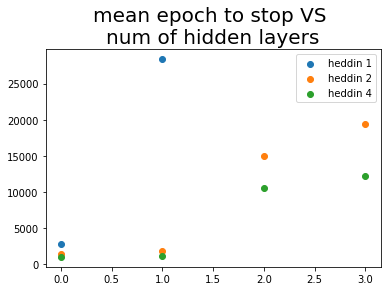

In [ ]:
plt.scatter(range(len(hidden_layers_1)), hidden_layers_1, label='heddin 1')
plt.scatter(range(len(hidden_layers_2)), hidden_layers_2, label='heddin 2')
plt.scatter(range(len(hidden_layers_4)), hidden_layers_4, label='heddin 4')

plt.title('mean epoch to stop VS \nnum of hidden neurons', fontsize=20)
plt.legend()
plt.show()

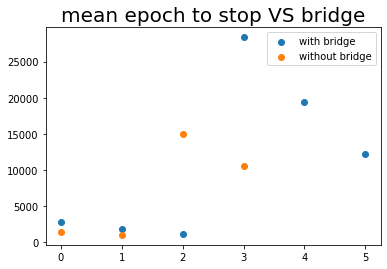

In [ ]:
plt.scatter(range(len(with_bridge)), with_bridge, label='with bridge')
plt.scatter(range(len(without_bridge)), without_bridge, label='without bridge')

plt.title('mean epoch to stop VS bridge', fontsize=20)
plt.legend()
plt.show()

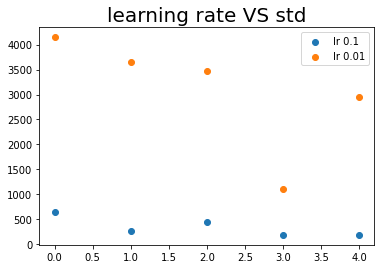

In [ ]:
plt.scatter(range(len(lr_01)), lr_01, label='lr 0.1')
plt.scatter(range(len(lr_001)), lr_001, label='lr 0.01')

plt.title('learning rate VS std', fontsize=20)
plt.legend()
plt.show()